## Mapping Dominant Cancers to Causal Risk Factors

In [ ]:
%pip install pandas scikit-learn matplotlib seaborn xgboost shap lightgbm plotly nbformat ipython 

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [65]:
# Load original data
norm = pd.read_csv("normalized_data.csv")
dominant = pd.read_csv("dominant_cancer_types_all_filled_rf.csv")

# Clean country names
norm["country_name"] = norm["country_name"].str.strip()
dominant["country_name"] = dominant["country_name"].str.strip()

# Merge dominant cancer labels into full dataset (country-year)
df = norm.merge(dominant[["country_name", "highest_incidence_cancer"]], on="country_name", how="left")

# Keep one row per country–year (collapse to aggregate risk factors)
features = [
    "air_pollution", "alcohol_use", "gdp_per_capita",
    "uhc_index", "obesity_rate", "tobacco_use"
]

# Group by country + year, then average the risk factors
risk_data = df.groupby(["country_name", "year"])[features].mean().reset_index()

# Merge the label (based on country only — not year-dependent in this case)
label_data = dominant[["country_name", "highest_incidence_cancer"]]
risk_data = risk_data.merge(label_data, on="country_name", how="left")

# Create binary label: Lung = 1, Others = 0
risk_data["target"] = (risk_data["highest_incidence_cancer"] == "Lung").astype(int)

# Drop NAs
risk_data = risk_data.dropna(subset=features + ["target"])

# Final X and y
X = risk_data[features]
y = risk_data["target"]

In [66]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, stratify=y, test_size=0.25, random_state=42
)

# DataFrame for SHAP
X_test_df = pd.DataFrame(X_test, columns=features)

📘 Random Forest
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       297
           1       0.98      0.89      0.94        65

    accuracy                           0.98       362
   macro avg       0.98      0.94      0.96       362
weighted avg       0.98      0.98      0.98       362



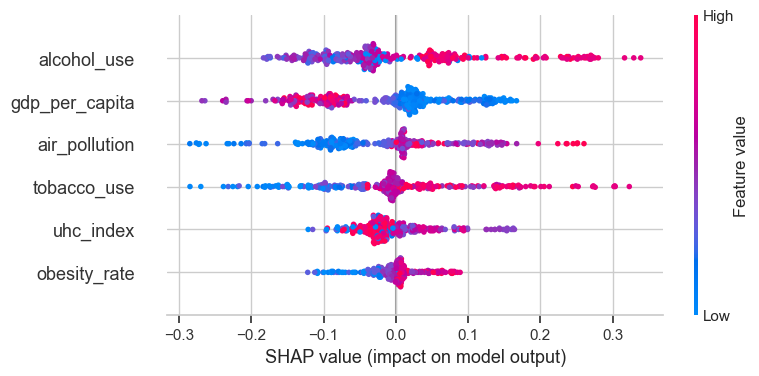

In [67]:
# Random Forest
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("📘 Random Forest")
print(classification_report(y_test, y_pred_rf))

# SHAP
explainer_rf = shap.Explainer(rf, X_test_df)
shap_values_rf = explainer_rf(X_test_df)
shap.plots.beeswarm(shap_values_rf[:, :, 1])  # Class 1 = lung dominant

/Users/mira-ali/BAU/data_analytics/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:13:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


📙 XGBoost
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       297
           1       0.95      0.95      0.95        65

    accuracy                           0.98       362
   macro avg       0.97      0.97      0.97       362
weighted avg       0.98      0.98      0.98       362



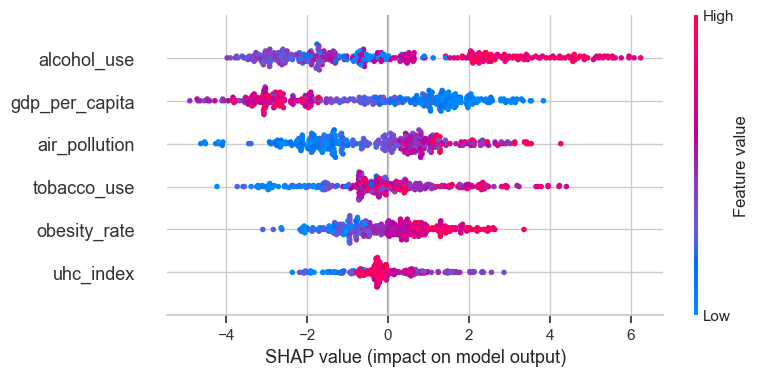

In [71]:
xgb = XGBClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
                    use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("📙 XGBoost")
print(classification_report(y_test, y_pred_xgb))

explainer_xgb = shap.Explainer(xgb, X_test_df)
shap_values_xgb = explainer_xgb(X_test_df)
shap.plots.beeswarm(shap_values_xgb)

[LightGBM] [Info] Number of positive: 196, number of negative: 887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1246
[LightGBM] [Info] Number of data points in the train set: 1083, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/Users/mira-ali/BAU/data_analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


📗 LightGBM
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       297
           1       0.95      0.95      0.95        65

    accuracy                           0.98       362
   macro avg       0.97      0.97      0.97       362
weighted avg       0.98      0.98      0.98       362



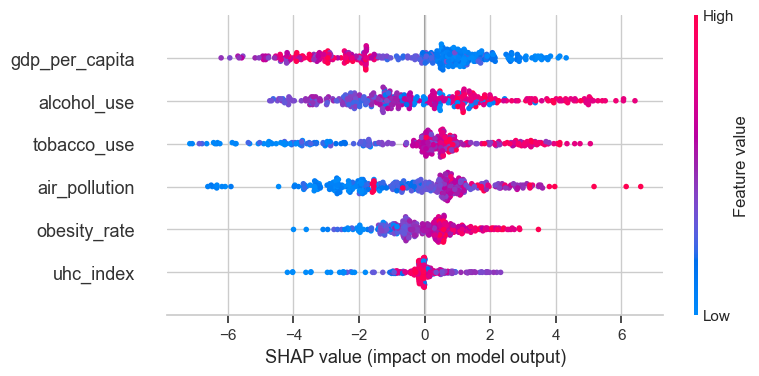

In [73]:

# 🟢 Train LightGBM model
lgbm = LGBMClassifier(class_weight="balanced", random_state=42)
lgbm.fit(X_train, y_train)

# 🟢 Evaluate
y_pred_lgb = lgbm.predict(X_test)
print("📗 LightGBM")
print(classification_report(y_test, y_pred_lgb))

# 🟢 SHAP Explainer — disable additivity check to avoid error
explainer_lgb = shap.Explainer(lgbm, X_test_df)
shap_values_lgb = explainer_lgb(X_test_df, check_additivity=False)

# 🟢 Plot SHAP beeswarm
shap.plots.beeswarm(shap_values_lgb)

In [89]:
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.io as pio
import pandas as pd

# Step 1: Create DataFrame from test set and y_test
X_test_df = pd.DataFrame(X_test, columns=features).reset_index(drop=True)
y_test_df = y_test.reset_index(drop=True)

# Step 2: Filter for lung-dominant test rows
lung_mask = y_test_df == 1
lung_X = X_test_df[lung_mask].reset_index(drop=True)
lung_shap = shap_values_xgb.values[lung_mask.values]  # align SHAP values to filtered rows

# Step 3: Build SHAP DataFrame
shap_vals_df = pd.DataFrame(lung_shap, columns=features)
shap_vals_df["top_driver"] = shap_vals_df[features].idxmax(axis=1)

# Optional: add placeholder country/year if needed
shap_vals_df["sample"] = shap_vals_df.index

# Step 4: PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(shap_vals_df[features])

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2", "PC3"])
pca_df["top_driver"] = shap_vals_df["top_driver"]
pca_df["sample"] = shap_vals_df["sample"]

# Step 5: Plot
fig = px.scatter_3d(
    pca_df,
    x="PC1", y="PC2", z="PC3",
    color="top_driver",
    hover_data=["sample"],
    title="3D PCA of SHAP Values for Lung Cancer Incidence (Test Set Only)"
)

pio.write_html(fig, file="lung_shap_3d_testset.html", auto_open=True)

/var/folders/1d/k5qf2m1x45nd7l3rh4619t8r0000gp/T/ipykernel_72786/2443938656.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/1d/k5qf2m1x45nd7l3rh4619t8r0000gp/T/ipykernel_72786/2443938656.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/1d/k5qf2m1x45nd7l3rh4619t8r0000gp/T/ipykernel_72786/2443938656.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/1d/k5qf2m1x45nd7l3rh4619t8r0000gp/T/ipykernel_72786/2443938656.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign 

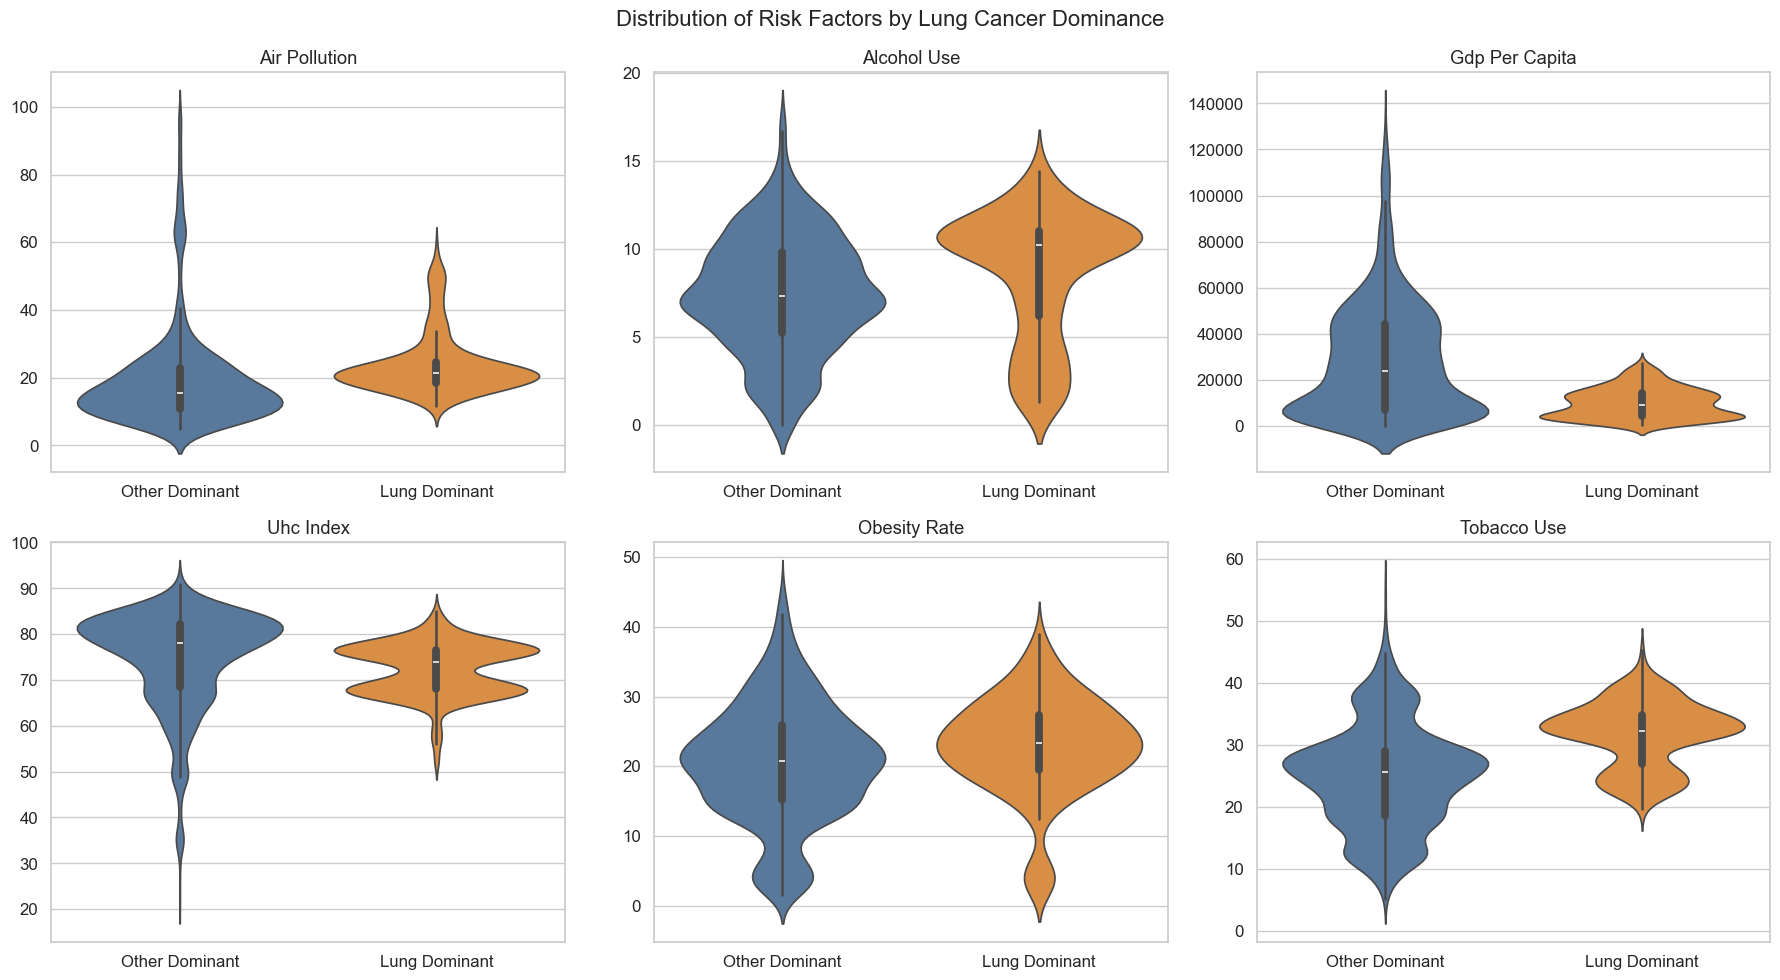

In [93]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Merge features and target
plot_df = risk_data[features + ["country_name", "year"]].copy()
plot_df["lung_dominant"] = y.reset_index(drop=True)

# Optional: readable labels
plot_df["lung_dominant"] = plot_df["lung_dominant"].map({0: "Other Dominant", 1: "Lung Dominant"})

# Step 2: Set plot style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# Step 3: Create violin plots
num_features = len(features)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))  # adjust grid based on # features
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.violinplot(
        data=plot_df,
        x="lung_dominant",
        y=feature,
        ax=axes[i],
        palette=["#4e79a7", "#f28e2c"]
    )
    axes[i].set_title(feature.replace("_", " ").title())
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Remove extra subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Distribution of Risk Factors by Lung Cancer Dominance", fontsize=16)
plt.tight_layout()
plt.show()

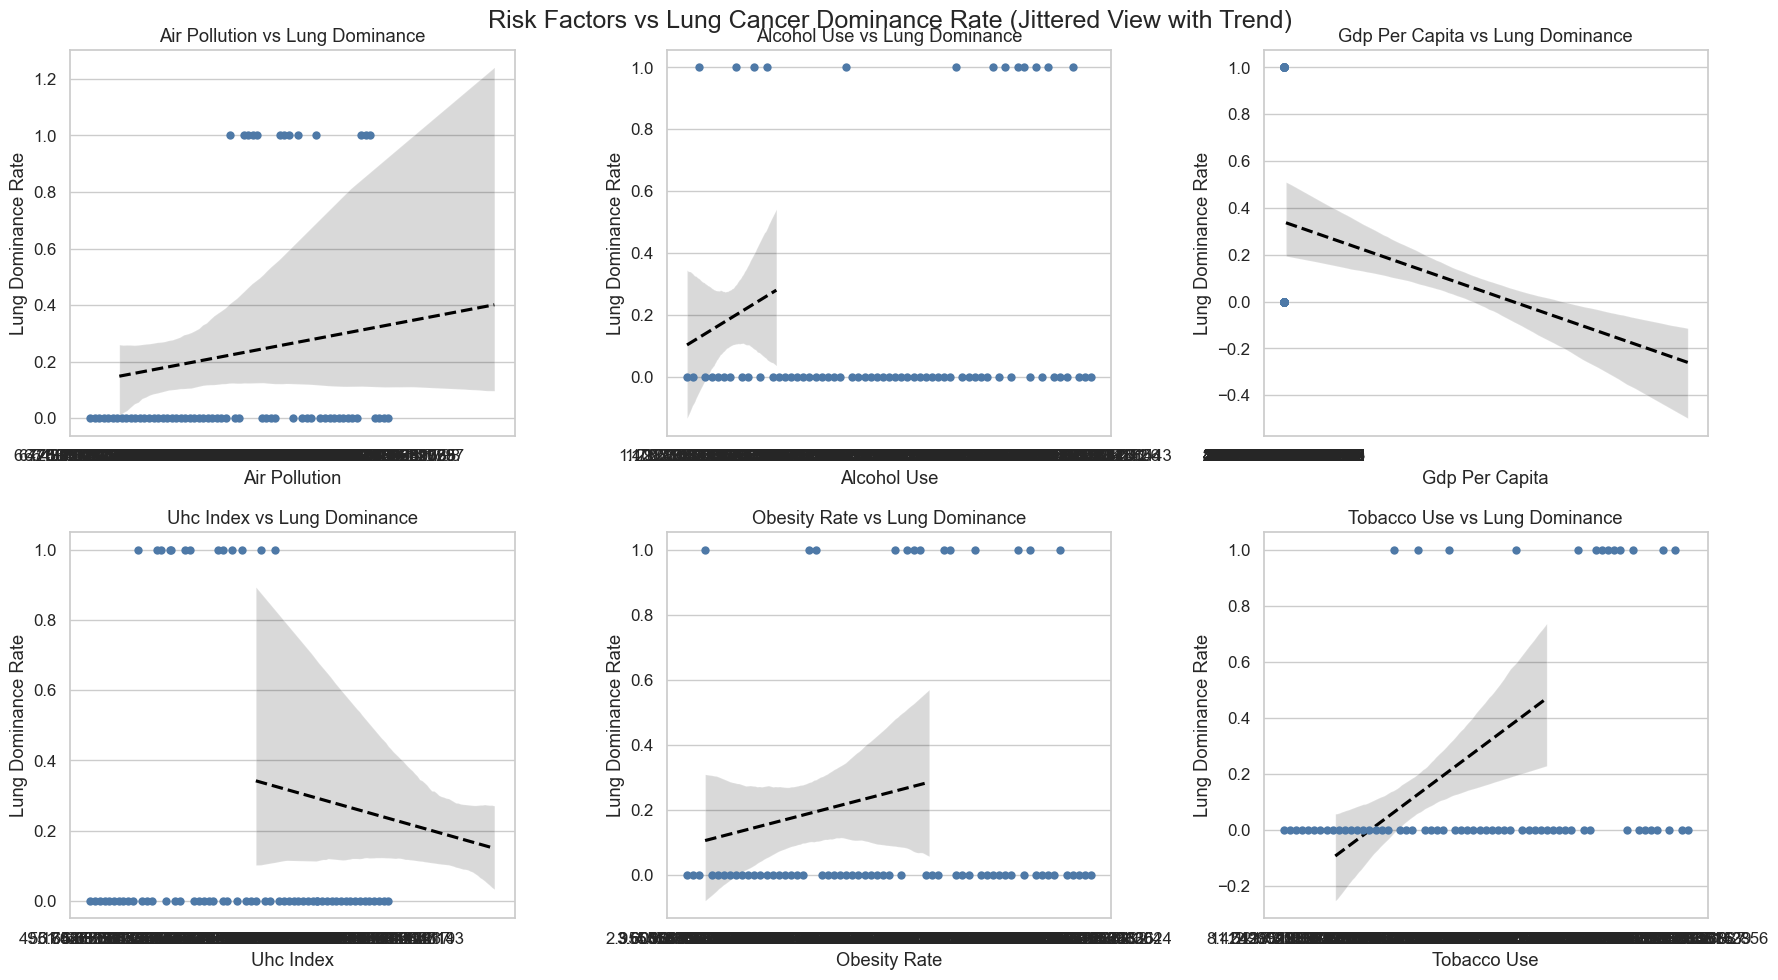

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", font_scale=1.1)

# Setup subplots
num_features = len(features)
cols = 3
rows = (num_features + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]
    
    # Scatter with jitter
    sns.stripplot(
        data=country_df,
        x=feature,
        y="lung_dominance_rate",
        ax=ax,
        color="#4e79a7",
        jitter=0.15,
        size=6
    )
    
    # Add a trend/regression line
    sns.regplot(
        data=country_df,
        x=feature,
        y="lung_dominance_rate",
        scatter=False,
        ax=ax,
        color="black",
        line_kws={"linestyle": "dashed"}
    )

    ax.set_title(f"{feature.replace('_', ' ').title()} vs Lung Dominance")
    ax.set_ylabel("Lung Dominance Rate")
    ax.set_xlabel(feature.replace("_", " ").title())

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Risk Factors vs Lung Cancer Dominance Rate (Jittered View with Trend)", fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.94)
plt.show()